In [52]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

In [53]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()):
    if "anuja" in os.environ.get('USER'):
        DATA_DIR = 'data/'
    elif 'ubuntu' in os.environ.get('USER'):
        DATA_DIR = '/home/ubuntu/Martyna/repo/AI4Health/DATAfoof/'
    

In [56]:
path = os.path.join(DATA_DIR, 'split_data')
#loading
train_features = pd.read_pickle(os.path.join(path, 'train_features_source.pkl'))
test_features = pd.read_pickle(os.path.join(path, 'test_features_source_classification.pkl'))
train_labels = pd.read_pickle(os.path.join(path, 'train_labels_classification.pkl'))
test_labels = pd.read_pickle(os.path.join(path, 'test_labels_classification.pkl'))

train_features = np.array(train_features)
test_features = np.array(test_features)
train_labels = np.array(train_labels) 
test_labels = np.array(test_labels) 

In [57]:
age_gender = True
if age_gender:
    train_age_gender = train_features[:,-2:]
    test_age_gender = test_features[:,-2:]
    train_features = train_features[:,:-2]
    test_features = test_features[:,:-2]

## DATA NORMALISATION

In [58]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1440, 2788) (481, 2788)


## PCA

In [59]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features)

# transform data
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape, test_features.shape)

(1440, 421) (481, 421)


In [60]:
if age_gender:
    train_features = np.concatenate([train_features, train_age_gender], axis = 1)
    test_features = np.concatenate([test_features, test_age_gender], axis = 1)

## Metrics

In [61]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict() #actually stores AUC
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
#         average_precision[i] = auc(recall[i], precision[i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])
#         average_precision[i] = auc(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
#     average_precision["micro"] = auc(recall["micro"], precision["micro"])
    average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

#     average_precision["macro"] = np.average(list(average_precision.values()))

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")
    plt.show()
    
    return average_precision["micro"]
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#     roc_auc["macro"] = np.average(list(roc_auc.values()))
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operator characteristics')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc["micro"]

In [62]:

def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    accuracy = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    brier_score = brier_multi(y_test, y_pred_prob)
    report = skm.classification_report(y_test,y_pred, zero_division=1, output_dict=True)
    
    print("Accuracy:", accuracy)
    print("Hamming Loss:", hamming)
    if brier:
        print("Brier Score:", brier_score)
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))
    
    return accuracy,  hamming, brier_score, report

## MODELS

In [63]:
model_names, model_names_all = [], []
accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc = [], [], [], [], [], [], [], []
accuracy_scores_all, hamming_all, brier_score_all, precision_all, recall_all, f1_score_all, pr_auc_all, roc_auc_all = [], [], [], [], [], [], [], []
accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std = [], [], [], [], [], [], [], []

def record_values(a, h, b, p, r, f, pr, roc,a_std, h_std, b_std, p_std, r_std, f_std, pr_std, roc_std, model_name=''):
    accuracy_scores.append(a)
    hamming.append(h)
    brier_score.append(b)
    precision.append(p)
    recall.append(r)
    f1_score.append(f)
    pr_auc.append(pr)
    roc_auc.append(roc)
    
    accuracy_scores_std.append(a_std)
    hamming_std.append(h_std)
    brier_score_std.append(b_std)
    precision_std.append(p_std)
    recall_std.append(r_std)
    f1_score_std.append(f_std)
    pr_auc_std.append(pr_std)
    roc_auc_std.append(roc_std)
    model_names.append(model_name)

def record_values_all(a, h, b, p, r, f, pr, roc, model_name=''):
    accuracy_scores_all.append(a)
    hamming_all.append(h)
    brier_score_all.append(b)
    precision_all.append(p)
    recall_all.append(r)
    f1_score_all.append(f)
    pr_auc_all.append(pr)
    roc_auc_all.append(roc)
    model_names_all.append(model_name)

In [64]:
def ci(vals):
    return np.percentile(vals, 5), np.percentile(vals, 95)

In [65]:
# specify runs here
n = 100

## RANDOM BASELINE

### Shuffling

In [66]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_shuffled = np.copy(test_labels)
    np.random.shuffle(predicted_labels_shuffled)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_shuffled)
    pr = plot_pr_curve(test_labels, predicted_labels_shuffled)
    roc = plot_roc_curve(test_labels, predicted_labels_shuffled)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Shuffling Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Shuffling Baseline')

## MULTI OUTPUT CLASSIFIER

In [ ]:
%%capture

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

forest = RandomForestClassifier() 
lg = LogisticRegression()
models = [lg, forest]
number_of_bootstraps = 10
seed_value = 7

for model in models:
    if str(model) == "RandomForestClassifier()":
        name = 'RandFor'  
    elif str(model) == "LogisticRegression()":
        name = 'LogReg'

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []
    for i in range(n):

        multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
        multi_output_model.fit(train_features, train_labels)

        # Boostrap
        resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

        predicted_labels = np.asarray(multi_output_model.predict_proba(resampled_xtest))[:, :, 1].T
        print(str(model)+':')
        accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels)
        pr = plot_pr_curve(resampled_ytest, predicted_labels)
        roc = plot_roc_curve(resampled_ytest, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)
        record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MOC-'+str(name))
    
    
    vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
    means = [np.mean(v) for v in vals]
    cis = [ci(v) for v in vals]
    record_values(*means, *cis, 'MOC-'+str(name))

## Label Powerset

In [71]:
%%capture

from skmultilearn.problem_transform import LabelPowerset

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = LabelPowerset(LogisticRegression())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    
    predicted_labels_lp = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_lp.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_lp.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'LP-LogReg')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'LP-LogReg')

In [72]:
%%capture

from sklearn.ensemble import RandomForestClassifier

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):

    classifier = LabelPowerset(RandomForestClassifier())
    classifier.fit(train_features, train_labels)

    predicted_labels_lp = classifier.predict_proba(test_features)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_lp.toarray())
    pr = plot_pr_curve(test_labels, predicted_labels_lp.toarray())
    roc = plot_roc_curve(test_labels, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'LP-RandFor')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'LP-RandFor')

In [73]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg),np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))


0.10509355509355509 0.23870841995841996 1.3595817983367984 0.5836242574517863 0.28751248751248754 0.38523076824143765 0.4618938667698778 0.7086527803071533 0.0030466425966222135 0.0009911950386976883 0.004975174616624833 0.0043541206812437155 0.0027102217714786276 0.0026789542437286127 0.0063476011211635154 0.0035675843434633007


## Visualisation

In [74]:
%matplotlib inline


[0.04521829521829522, 0.058212058212058215, 0.0970893970893971, 0.057380457380457384, 0.0393970893970894, 0.055925155925155935, 0.08461538461538462, 0.10509355509355509] [(0.031185031185031187, 0.05415800415800416), (0.04563409563409564, 0.07297297297297298), (0.07640332640332641, 0.10841995841995843), (0.03908523908523909, 0.07920997920997921), (0.02671517671517672, 0.05218295218295219), (0.0393970893970894, 0.07276507276507277), (0.07047817047817048, 0.09646569646569648), (0.10166320166320167, 0.10821205821205822)]


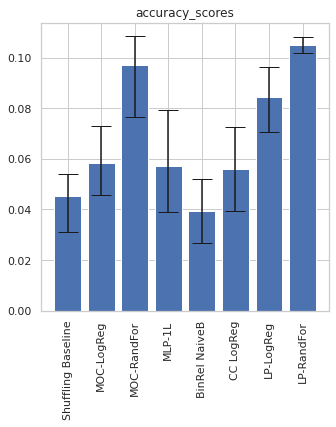

[0.3341735966735967, 0.2838617463617464, 0.24545218295218296, 0.30423596673596676, 0.33496621621621625, 0.28114604989604985, 0.2590046777546777, 0.23870841995841996] [(0.3247141372141372, 0.3426455301455301), (0.2708549896049896, 0.2971023908523909), (0.23639553014553014, 0.2564579002079002), (0.2908264033264033, 0.31700883575883576), (0.32562370062370066, 0.3498310810810811), (0.268256237006237, 0.29555613305613304), (0.24763513513513513, 0.2727780665280665), (0.23699324324324328, 0.23990384615384613)]


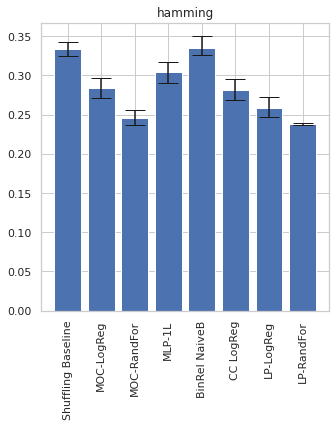

[2.6733887733887736, 1.6205825699448577, 1.4069656133056132, 2.084819942561669, 2.086567345114958, 1.654855391131154, 1.4816107605306676, 1.3595817983367984] [(2.5977130977130978, 2.741164241164241), (1.5598107298761554, 1.686702445917132), (1.3739448128898128, 1.4495865592515593), (2.0010792810090274, 2.1793481174895737), (2.0326619903524272, 2.1566009505972508), (1.5896859121734985, 1.7289173285440218), (1.4358405963174081, 1.539166785573795), (1.3502538877338879, 1.367985374220374)]


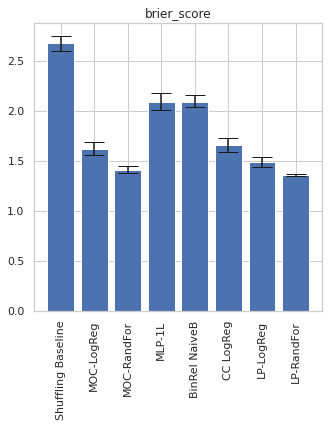

[0.35769230769230764, 0.4411868867536641, 0.5633195185939861, 0.4040202592882629, 0.3855241808701723, 0.445868218725941, 0.5092244926820546, 0.5836242574517863] [(0.3414085914085914, 0.3758741258741259), (0.41871719588226763, 0.47478776735829986), (0.5299714791502754, 0.5896724643475943), (0.37340331262939963, 0.4344061013724691), (0.3640262609853836, 0.41059496284726943), (0.42365672990063236, 0.4850664922607369), (0.4813326410522672, 0.5354551102605118), (0.5778878787878787, 0.5910437794749802)]


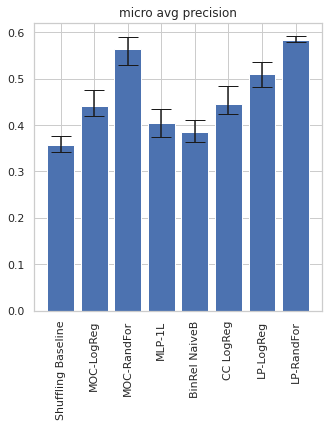

[0.35769230769230764, 0.32020947792099336, 0.2737155235837075, 0.34153221932363176, 0.47240176220131486, 0.3090942550351623, 0.27266757145601134, 0.28751248751248754] [(0.3414085914085914, 0.3758741258741259), (0.2972874874420715, 0.34105137017490883), (0.2577366707538793, 0.28497091910400135), (0.31652952401702433, 0.3631285323201161), (0.4469314517279758, 0.4965486644694376), (0.2867320759201046, 0.33246900456560013), (0.25470515491376766, 0.29082193689337055), (0.2827172827172827, 0.2908591408591409)]


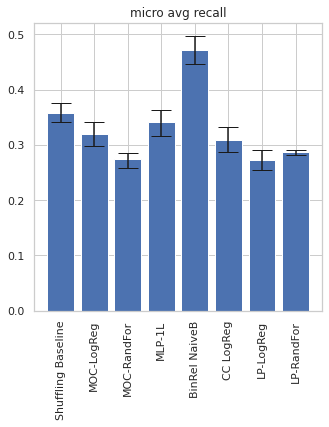

[0.35769230769230764, 0.370949331754956, 0.3683658156297823, 0.3697564571701893, 0.42439330514764634, 0.3649623558903856, 0.3549870461503792, 0.38523076824143765] [(0.3414085914085914, 0.37587412587412583), (0.3514039107403383, 0.39684510365857517), (0.35204974174737824, 0.3842468930722027), (0.35057544501022764, 0.39687275616437134), (0.4031267937091034, 0.44050982484079537), (0.34614632865602846, 0.3945260906464162), (0.3359511077158135, 0.3713631175096984), (0.3806065823210153, 0.38904665837643015)]


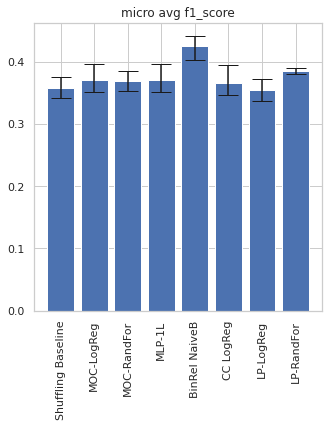

[0.29514520346813056, 0.3926304214689942, 0.4423196668219152, 0.37175321046907256, 0.36512023818391326, 0.3845925039801808, 0.4328519306889437, 0.4618938667698778] [(0.28788377648892133, 0.30363961223726466), (0.3741233104204296, 0.41613449000337394), (0.4227542026489534, 0.46349028686777616), (0.35149767403089294, 0.40038057524025294), (0.3492358274169762, 0.38341635992440853), (0.36879175014935067, 0.40489507062044167), (0.4153729183242561, 0.45006862430030126), (0.4519404158497808, 0.4709852901101855)]


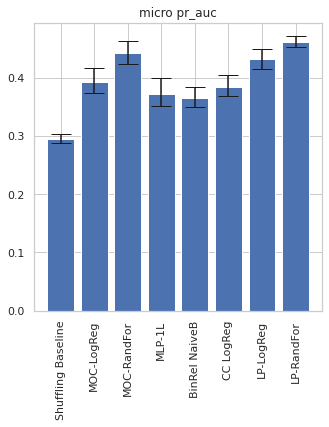

[0.565929048120829, 0.6524386174739343, 0.6966868316541178, 0.6227915539235717, 0.6235792003556357, 0.644228337149553, 0.6750138755831208, 0.7086527803071533] [(0.5549245275272673, 0.5782163042437015), (0.6405139472231506, 0.665676530839861), (0.6840550174446195, 0.7061925043045918), (0.6071193896110971, 0.6366332912196682), (0.6088206599277659, 0.6393964974053952), (0.631774476756169, 0.6576400404271163), (0.6649573051004312, 0.6901564939596827), (0.703708260478545, 0.7144899884099041)]


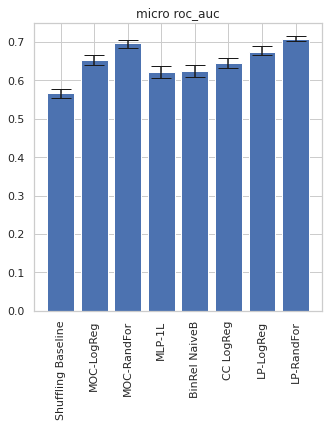

In [75]:
import matplotlib.pyplot as plt

score_names = ['accuracy_scores', 'hamming', 'brier_score', 'micro avg precision', 'micro avg recall', 'micro avg f1_score', 'micro pr_auc', 'micro roc_auc']
for scores, scores_std, score_name in zip([accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc],[accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std], score_names):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([0,0,1,1])
    print(scores, scores_std)
    scores_std = np.array(list(zip(*scores_std)))
    scores_std[0] = scores - scores_std[0]
    scores_std[1] = scores_std[1] - scores
    ax.bar(model_names, scores, yerr = scores_std, capsize=10)
    plt.xticks(rotation='vertical')
    plt.title(score_name)
    plt.show()

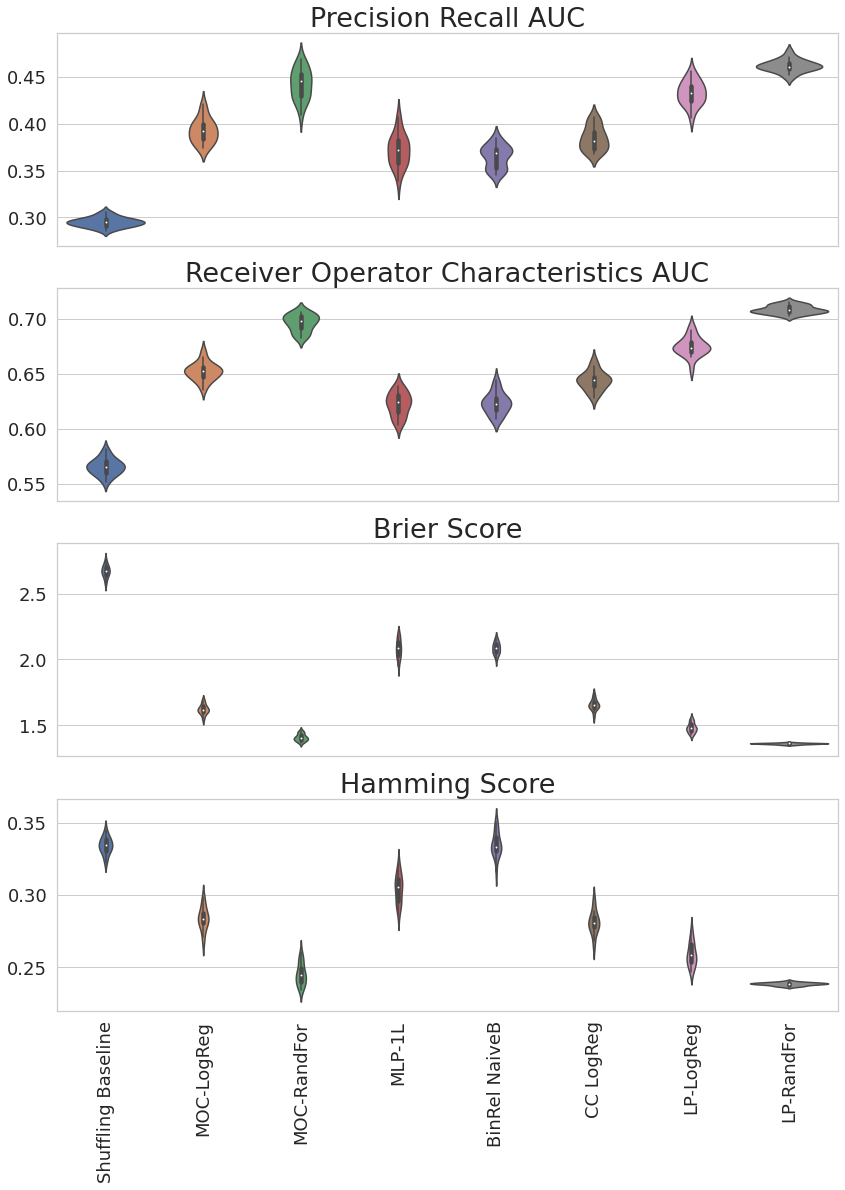

In [76]:
import seaborn as sns
#sns.set(style="whitegrid")

# plot
fig, axes = plt.subplots(4, 1, figsize=(14,18), sharex=True)
fig.suptitle("", fontsize = 25)
sns.violinplot(y=hamming_all, x=model_names_all, ax=axes[3])
axes[3].set_title('Hamming Score',fontsize = 27)
plt.xticks(fontsize=18)
axes[3].tick_params(axis='both', which='major', labelsize=18)


# plot
sns.violinplot(y=brier_score_all, x=model_names_all, ax=axes[2])
axes[2].set_title('Brier Score', fontsize = 27)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(3,16)})
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
axes[2].tick_params(axis='y', which='major', labelsize=18)




# plot

sns.violinplot(y=pr_auc_all, x=model_names_all, ax=axes[0])
axes[0].set_title("Precision Recall AUC", fontsize =27)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(16,16)})
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
axes[0].tick_params(axis='y', which='major', labelsize=18)




sns.violinplot(y=roc_auc_all, x=model_names_all, ax=axes[1])
axes[1].set_title("Receiver Operator Characteristics AUC", fontsize = 27)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(16, 16)})
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
axes[1].tick_params(axis='y', which='major', labelsize=18)



# plt.show()